# Neural Machine Translation ( Telugu - English )

In this Notebook, we will be developing a neural machine translation system for translating Telugu phrases to English.

Steps:

* Prepare Data
* Preprocess Data
* Text to Sequence Conversion
* Build Encoder-Decoder Model
* Train Model
* Translate Telugu to English

In this Notebook, The [Telugu-English](https://github.com/SRIDEV93/Language-Translation-Using-Machine-Learning-Telugu-to-English-/blob/main/English.txt) Bilingual-Sentence-Pairs data is used for Neural Machine Translation.

In [1]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
# List files in your Drive
import os
os.listdir('/content/drive/My Drive/')


['Getting started.pdf',
 'Untitled spreadsheet (1).gsheet',
 '53527669_ticket.pdf',
 'Untitled spreadsheet.xlsx',
 'resume.pdf',
 'memory challenge 2020.gdoc',
 'AUCTION WAR-2020.gdoc',
 'QUIZZAIRE 2020.gdoc',
 '6 class.gdoc',
 'Untitled spreadsheet.gsheet',
 'Colab Notebooks',
 'deep_learning',
 'NLP -1',
 'Untitled presentation.gslides',
 'demo',
 'braminen',
 'dl_project']

In [3]:
project_path = ""

In [4]:
import pandas as pd
import string
from string import digits
import re
import os
from numpy import array, argmax, random, take
from sklearn.model_selection import train_test_split
import pandas as pd
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Embedding, RepeatVector,TimeDistributed
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping,ReduceLROnPlateau
from tensorflow.keras.models import load_model
from tensorflow.keras import optimizers
import matplotlib.pyplot as plt
%matplotlib inline
# pd.set_option('display.max_colwidth', 200)

## Load Data

In [5]:
# Function to load sentences from a text file
def load_text_file(file_path):
    with open(file_path, 'r', encoding='utf-8') as file:
        lines = file.readlines()
    return [line.strip() for line in lines]  # Strip newlines and extra spaces

# File paths
train_en_path = "/content/drive/My Drive/NLP -1/English-Telugu-20241116T070209Z-001 (3)/English-Telugu-20241116T070209Z-001/English.txt"
train_te_path = "/content/drive/My Drive/NLP -1/English-Telugu-20241116T070209Z-001 (3)/English-Telugu-20241116T070209Z-001/Telugu.txt"


# Load English and Telugu sentences for all datasets
train_en = load_text_file(train_en_path)
train_te = load_text_file(train_te_path)


# Combine all English and Telugu sentences
english_sentances = train_en
telugu_sentances = train_te

# Print lengths to verify
print(f"Total English sentences: {len(english_sentances)}")
print(f"Total Telugu sentences: {len(telugu_sentances)}")


Total English sentences: 148441
Total Telugu sentences: 148441


In [6]:
data = pd.DataFrame({"english_sentances":english_sentances,"telugu_sentances":telugu_sentances})

In [7]:
data.head()

,english_sentances,telugu_sentances
0,His legs are long.,అతని కాళ్ళు పొడవుగా ఉన్నాయి.
1,I swim in the sea every day.,నేను ప్రతి రోజు సముద్రంలో ఈత కొడతాను.
2,Tom popped into the supermarket on his way hom...,టామ్ కొంచెం పాలు కొనడానికి ఇంటికి వెళ్ళేటప్పుడ...
3,Smoke filled the room.,పొగ గదిని నింపింది.
4,Tom and Mary understood each other.,టామ్ మరియు మేరీ ఒకరినొకరు అర్థం చేసుకున్నారు.


In [8]:
data.shape

(148441, 2)

## Text Pre-Processing

#### Text Cleaning

In [10]:
contraction_mapping = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not",
                           "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not",
                           "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",
                           "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would",
                           "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",
                           "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam",
                           "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have",
                           "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock",
                           "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have",
                           "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is",
                           "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as",
                           "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",
                           "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have",
                           "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have",
                           "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are",
                           "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",
                           "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is",
                           "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have",
                           "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",
                           "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all",
                           "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",
                           "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",
                           "you're": "you are", "you've": "you have"}

In [11]:
# clean english sentances
def clean_eng(text):
    # Lowercase all characters
    text = text.lower()
    # map contractions
    text = ' '.join([contraction_mapping[w] if w in contraction_mapping else w for w in text.split(" ")])
    # Remove quotes
    text = re.sub("'", '', text)
    # Remove all the special characters
    exclude = set(string.punctuation) # Set of all special characters
    text = ''.join([c for c in text if c not in exclude])
    # Remove all numbers from text
    remove_digits = str.maketrans('', '', digits)
    text = text.translate(remove_digits)
    # Remove extra spaces
    text= text.strip()

    return text

In [12]:
# clean telugu sentances
def clean_tel(text):
    # Lowercase all characters
    text = text.lower()
    # Remove quotes
    text = re.sub("'", '', text)
    # Remove all the special characters
    exclude = set(string.punctuation) # Set of all special characters
    text = ''.join([c for c in text if c not in exclude])
    # Remove all numbers from text
    remove_digits = str.maketrans('', '', digits)
    text = text.translate(remove_digits)
    # Remove Telugu numbers from text
    text = re.sub("[౦౧౨౩౪౫౬౭౮౯]", '', text)
    # Remove extra spaces
    text= text.strip()

    return text

In [13]:
# clean text
data_df = data.copy()
data_df["english_sentances"] = data_df["english_sentances"] .apply(lambda x: clean_eng(x))
data_df["telugu_sentances"] = data_df["telugu_sentances"] .apply(lambda x: clean_tel(x))
print(len(data_df))

148441


In [14]:
data_df.head()

,english_sentances,telugu_sentances
0,his legs are long,అతని కాళ్ళు పొడవుగా ఉన్నాయి
1,i swim in the sea every day,నేను ప్రతి రోజు సముద్రంలో ఈత కొడతాను
2,tom popped into the supermarket on his way hom...,టామ్ కొంచెం పాలు కొనడానికి ఇంటికి వెళ్ళేటప్పుడ...
3,smoke filled the room,పొగ గదిని నింపింది
4,tom and mary understood each other,టామ్ మరియు మేరీ ఒకరినొకరు అర్థం చేసుకున్నారు


#### Text to Sequence Conversion

Maximum sentence length in English: 101
Maximum sentence length in Telugu: 27


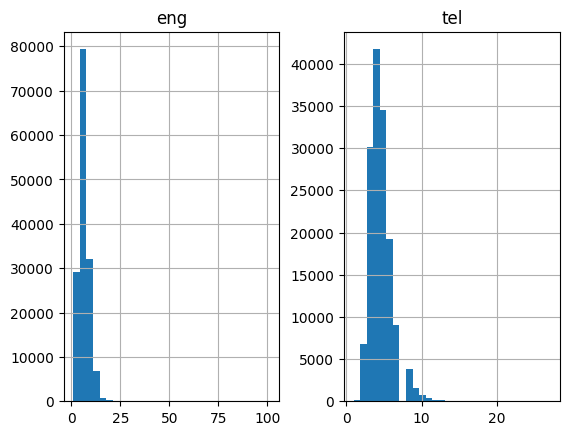

In [15]:
# empty lists
eng_l = []
tel_l = []

# populate the lists with sentence lengths
for i in data_df["english_sentances"].values:
    eng_l.append(len(i.split()))

for i in data_df["telugu_sentances"].values:
    tel_l.append(len(i.split()))

# Create a DataFrame
length_df = pd.DataFrame({'eng': eng_l, 'tel': tel_l})

# Find and print max lengths
max_eng_length = max(eng_l)
max_tel_length = max(tel_l)

print(f"Maximum sentence length in English: {max_eng_length}")
print(f"Maximum sentence length in Telugu: {max_tel_length}")

# Plot histograms
length_df.hist(bins=30)
plt.show()


Quite intuitive – the maximum length of the Telugu sentences is 101 and that of the English phrases is 27.

Next, we vectorized our text data by using Keras’s Tokenizer() class. It will turn our sentences into sequences of integers. We then padded those sequences with zeros to make all the sequences of the same length.

Note that we prepared tokenizers for both the Telugu and English sentences:

In [16]:
# function to build a tokenizer
def tokenization(lines):
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(lines)
    return tokenizer

In [17]:
# prepare english tokenizer
eng_tokenizer = tokenization(data_df["english_sentances"])
eng_vocab_size = len(eng_tokenizer.word_index) + 1

eng_length = 101
print('English Vocabulary Size: %d' % eng_vocab_size)

English Vocabulary Size: 13620


In [18]:
# prepare Telugu tokenizer
tel_tokenizer = tokenization(data_df["telugu_sentances"])
tel_vocab_size = len(tel_tokenizer.word_index) + 1

tel_length = 27
print('Telugu Vocabulary Size: %d' % tel_vocab_size)

Telugu Vocabulary Size: 38055


The below code block contains a function to prepare the sequences. It will also perform sequence padding to a maximum sentence length as mentioned above.

In [19]:
# encode and pad sequences
def encode_sequences(tokenizer, length, lines):
    # integer encode sequences
    seq = tokenizer.texts_to_sequences(lines)
    # pad sequences with 0 values
    seq = pad_sequences(seq, maxlen=length, padding='post')
    return seq

Splitting the data into train and test set for model training and evaluation, respectively.

In [20]:
# split data into train and test set
train, test = train_test_split(data_df, test_size=0.1, random_state = 12)

We then encoded **Telugu sentences as the input sequences** and **English sentences as the target sequences**. This is done for both the train and test datasets.

In [21]:
# prepare training data
trainX = encode_sequences(tel_tokenizer, tel_length, train["telugu_sentances"])
trainY = encode_sequences(eng_tokenizer, eng_length, train["english_sentances"])

# prepare validation data
testX = encode_sequences(tel_tokenizer, tel_length, test["telugu_sentances"])
testY = encode_sequences(eng_tokenizer, eng_length, test["english_sentances"])

In [22]:
trainY = trainY.reshape((trainY.shape[0], trainY.shape[1], 1))
testY = testY.reshape((testY.shape[0], testY.shape[1], 1))


In [23]:
trainX.shape,trainY.shape,testX.shape,testY.shape

((133596, 27), (133596, 101, 1), (14845, 27), (14845, 101, 1))

## Build Model

For the encoder, we are using embedding layer and Multilayer Bidirectional LSTM layer
For the decoder, we are using Multilayer LSTM layer followed by a dense layer

In [25]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, Bidirectional, LSTM, RepeatVector, Dense, TimeDistributed

def define_bidirectional_lstm_model(in_vocab, out_vocab, in_timesteps, out_timesteps, units):
    # Encoder
    encoder_inputs = Input(shape=(in_timesteps,))
    encoder_embedding = Embedding(input_dim=in_vocab, output_dim=units, mask_zero=True)(encoder_inputs)

    # Multilayer Bidirectional LSTM for Encoder
    encoder_bi_lstm1 = Bidirectional(LSTM(units, return_sequences=True, use_cudnn=False))(encoder_embedding)
    encoder_bi_lstm2 = Bidirectional(LSTM(units, return_sequences=False, use_cudnn=False))(encoder_bi_lstm1)

    # Decoder
    decoder_inputs = RepeatVector(out_timesteps)(encoder_bi_lstm2)
    decoder_lstm1 = LSTM(units, return_sequences=True, use_cudnn=False)(decoder_inputs)
    decoder_lstm2 = LSTM(units, return_sequences=True, use_cudnn=False)(decoder_lstm1)
    decoder_dense = TimeDistributed(Dense(out_vocab, activation='softmax'))(decoder_lstm2)

    # Define the model
    model = Model(encoder_inputs, decoder_dense)
    return model




In [26]:
print(f"trainX shape: {trainX.shape}")
print(f"trainY shape: {trainY.shape}")


trainX shape: (133596, 27)
trainY shape: (133596, 101, 1)


In [27]:
# model compilation
model = define_bidirectional_lstm_model(tel_vocab_size,eng_vocab_size,tel_length,eng_length, 256)
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 27)             │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding (Embedding)     │ (None, 27, 256)        │      9,742,080 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ not_equal (NotEqual)      │ (None, 27)             │              0 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bidirectional             │ (None, 27, 512)        │      1,050,624 │ embedding[0][0],       │
│ (Bidirectional)           │                        │                │ not_equal[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bidirectional_1           │ (None, 512)            │      1,574,912 │ bidirectional[0][0],   │
│ (Bidirectional)           │                        │                │ not_equal[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ repeat_vector             │ (None, 101, 512)       │              0 │ bidirectional_1[0][0]  │
│ (RepeatVector)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm_2 (LSTM)             │ (None, 101, 256)       │        787,456 │ repeat_vector[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm_3 (LSTM)             │ (None, 101, 256)       │        525,312 │ lstm_2[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ time_distributed          │ (None, 101, 13620)     │      3,500,340 │ lstm_3[0][0]           │
│ (TimeDistributed)         │                        │                │                        │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 17,180,724 (65.54 MB)

 Trainable params: 17,180,724 (65.54 MB)

 Non-trainable params: 0 (0.00 B)

We are using the RMSprop optimizer in this model as it’s usually a good choice when working with recurrent neural networks.

In [28]:
rms = optimizers.RMSprop()
model.compile(optimizer=rms, loss='sparse_categorical_crossentropy')

Please note that we have used ‘sparse_categorical_crossentropy‘ as the loss function. This is because the function allows us to use the target sequence as is, instead of the one-hot encoded format. **One-hot encoding the target sequences using such a huge vocabulary might consume our system’s entire memory**.

**We will train it for 70 epochs and with a batch size of 64 with a validation split of 20%.** 80% of the data will be used for training the model and the rest for evaluating it.

We will also use the **ModelCheckpoint()** function to save the model with the lowest validation loss.

In [29]:
# Defining a helper function to save the model after each epoch
# in which the loss decreases
filepath = project_path+'NMT_model.keras'
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
# Defining a helper function to reduce the learning rate each time
# the learning plateaus
reduce_alpha = ReduceLROnPlateau(monitor ='val_loss', factor = 0.2, patience = 1, min_lr = 0.001)
# stop traning if there increase in loss
# es = EarlyStopping(monitor='val_loss', mode='min', verbose=1,patience=2)
callbacks = [checkpoint, reduce_alpha]

## Train Model

Comparing the training loss and the validation loss.

In [32]:
# train model
history = model.fit(trainX, trainY.reshape(trainY.shape[0], trainY.shape[1], 1),
                    epochs=70, batch_size=64, validation_split = 0.2,callbacks=callbacks, verbose=1)

Epoch 1/70
1670/1670 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step - loss: 0.7457
Epoch 1: val_loss improved from inf to 0.38863, saving model to NMT_model.keras
1670/1670 ━━━━━━━━━━━━━━━━━━━━ 390s 226ms/step - loss: 0.7456 - val_loss: 0.3886 - learning_rate: 0.0010
Epoch 2/70
1670/1670 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step - loss: 0.3869
Epoch 2: val_loss improved from 0.38863 to 0.38334, saving model to NMT_model.keras
1670/1670 ━━━━━━━━━━━━━━━━━━━━ 375s 225ms/step - loss: 0.3869 - val_loss: 0.3833 - learning_rate: 0.0010
Epoch 3/70
1670/1670 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step - loss: 0.3816
Epoch 3: val_loss improved from 0.38334 to 0.37896, saving model to NMT_model.keras
1670/1670 ━━━━━━━━━━━━━━━━━━━━ 377s 226ms/step - loss: 0.3816 - val_loss: 0.3790 - learning_rate: 0.0010
Epoch 4/70
1670/1670 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step - loss: 0.3768
Epoch 4: val_loss improved from 0.37896 to 0.37546, saving model to NMT_model.keras
1670/1670 ━━━━━━━━━━━━━━━━━━━━ 374s 224ms/step - loss: 0.3768 - val_l

In [33]:
import keras

In [34]:
# Save the model
model.save("translation_model.h5")

# Save the tokenizers
import pickle
with open("eng_tokenizer.pkl", "wb") as eng_file:
    pickle.dump(eng_tokenizer, eng_file)

with open("tel_tokenizer.pkl", "wb") as tel_file:
    pickle.dump(tel_tokenizer, tel_file)

# Save training history
with open("training_history.pkl", "wb") as history_file:
    pickle.dump(history.history, history_file)


In [35]:
# model = keras.saving.load_model("/kaggle/working/NMT_model.keras")

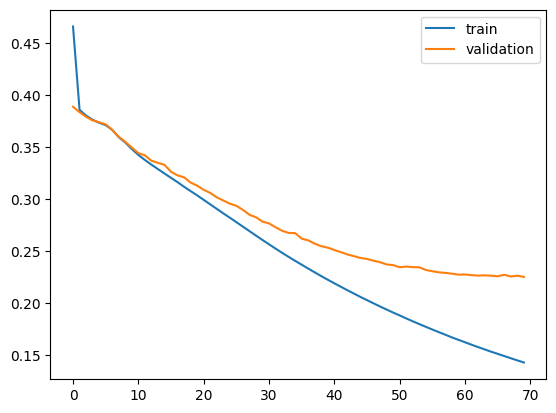

In [36]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['train','validation'])
plt.show()

# Calculating BERT Score on Test Data

In [37]:
# Function to decode a sequence of indices into text
def decode_sequence(tokenizer, sequence):
    if len(sequence.shape) == 1:  # Ensure the input is a list of sequences
        sequence = [sequence]
    return tokenizer.sequences_to_texts(sequence)[0]  # Decode and return the first element

# Generate predictions on the test set
def test_data_generator(data, batch_size):
    for i in range(0, len(data), batch_size):
        yield data[i:i + batch_size]

# Generate predictions using the generator
batch_size = 4
predictions = []
for batch in test_data_generator(testX, batch_size):
    batch_predictions = model.predict(batch, batch_size=batch_size)
    predictions.extend(batch_predictions)

# Decode predictions and ground truth
decoded_preds = []
decoded_targets = []

for i in range(len(predictions)):
    # Decode prediction
    pred_sequence = predictions[i].argmax(axis=-1)
    decoded_preds.append(decode_sequence(eng_tokenizer, pred_sequence))  # Decode to English

    # Decode ground truth
    target_sequence = testY[i].flatten()
    decoded_targets.append(decode_sequence(eng_tokenizer, target_sequence))  # Decode to English


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━

In [38]:
!pip install bert_score

In [114]:
from bert_score import score

# Calculate BERTScore
P, R, F1 = score(decoded_preds, decoded_targets, lang="en", rescale_with_baseline=True)  # Use "en" for English

# Display the average scores
print(f"Average Precision: {P.mean().item():.4f}")
print(f"Average Recall: {R.mean().item():.4f}")
print(f"Average F1 Score: {F1.mean().item():.4f}")



Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Precision: 0.7180
Recall: 0.7063
F1 Score: 0.7126


## Samples Test Sentence Translation along with their Bert Scores

In [141]:
# Print 2 sentences along with their BERT scores
print("\nSample Sentences with BERT Scores:")
for i in range(2):  # Display the first 5 sentences
    print(f"Predicted: {decoded_preds[i]}")
    print(f"Target: {decoded_targets[i]}")
    print(f"BERTScore Precision: {P[i].item():.4f}, Recall: {R[i].item():.4f}, F1: {F1[i].item():.4f}")
    print()



Sample Sentences with BERT Scores:
Predicted: i am going to do it myself
Target: i am going to do it myself
BERTScore Precision: 1.0000, Recall: 1.0000, F1: 1.0000

Predicted: i wonder why you were are
Target: i wonder why the dogs are barking
BERTScore Precision: 0.5037, Recall: 0.4923, F1: 0.4988



## Test Model

Finally, we loaded the saved model and made predictions on the unseen data – testX.

In [ ]:
# get 10 random ids of test samples
idx = random.randint(testX.shape[0], size=5)
# get 10 encoded english test samples
encoded_telugu_actual = testX[idx,:]
# get 10 actual english sentences
tel_actual = test["telugu_sentances"].values
tel_actual = tel_actual[idx]
# get 10 actual telugu sentences
actual = test["english_sentances"].values
actual = actual[idx]

In [ ]:
# load model weights
# model.load_weights(filepath)
# predict english sentence to telugu sentence
preds = model.predict(encoded_telugu_actual.reshape((encoded_telugu_actual.shape[0],encoded_telugu_actual.shape[1])))

These predictions are sequences of integers. We need to convert these integers to their corresponding words. Let’s define a function to do this:

In [132]:
def get_word(n, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == n:
            return word
    return None

Convert predictions into text (Telugu):

Let’s create a dataframe with original english and telugu sentances and translated telugu sentences:

In [138]:
import numpy as np

def get_word(n, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == n:
            return word
    return None

# Assuming you have a single tokenizer for both languages
# If you have separate tokenizers, replace 'tokenizer' with the appropriate one

# Predict
preds = model.predict(encoded_telugu_actual)

# If your model outputs probabilities, you might need to get the most likely token at each step
if preds.ndim == 3:  # (batch_size, sequence_length, vocab_size)
    preds = np.argmax(preds, axis=-1)

# Decode predictions
decoded_sentences = []
for pred in preds:
    sentence = []
    for token_index in pred:
        if token_index == 0:  # Assuming 0 is padding
            break
        word = get_word(token_index, eng_tokenizer)  # Use the same tokenizer here
        if word is not None:
            sentence.append(word)
    decoded_sentences.append(' '.join(sentence))

# Print some examples
for i in range(5):  # Print first 5 translations
    print(f"Telugu: {' '.join([get_word(idx, tel_tokenizer) for idx in encoded_telugu_actual[i] if idx != 0])}")
    print(f"Predicted English: {decoded_sentences[i]}")
    print()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
Telugu: టామ్ తన తల్లిదండ్రులు లేకుండా మ్యూజియంలోకి ప్రవేశించటానికి అనుమతించబడడని అతనికి తెలియదు
Predicted English: tom does does his the he would his his his of his his parents

Telugu: మీరు దీని నుండి పారిపోలేరు
Predicted English: you cannot get out out out

Telugu: టామ్ మేరీ కోసం అరువు తెచ్చుకున్న మరియు కోల్పోయిన దాని స్థానంలో కొత్త కెమెరాను కొన్నాడు
Predicted English: tom bought the book that that that mary he he he he he bought bought

Telugu: మేరీ నిన్న వెళ్లాలని టామ్ చెప్పాడు
Predicted English: tom said mary to go

Telugu: ఇది కూడా ఖరీదైనది
Predicted English: it is too expensive

